In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

## Parameters

In [2]:
# ========== Model parameters ========== #
mean_lambda = 0.01
gamma_lambda = 0.01
var_lambda = 1e-7
mean_q = 10
gamma_q = 1e-2
var_q = 0.1
beta = 1e-3

var_x = 1e-3
var_g = 5000

var_dx =  0.0
var_dg = 0


# ========== Simulation parameters ========== #
out_dir = '../data/new_sim'
dt = 0.01
dt_measument = 3 # in minutes
n_cells = 100 # number of cells that will be simulated
division_log_length = 2
save_dataset = False


### Simulation functions

In [3]:

parameter_set = {   "mean_lambda": mean_lambda, 
                    "gamma_lambda": gamma_lambda,
                    "var_lambda": var_lambda,
                    "mean_q": mean_q,
                    "gamma_q": gamma_q,
                    "var_q": var_q,
                    "beta": beta,
                    "var_x": var_x,
                    "var_g": var_g,
                    "var_dx": var_dx,
                    "var_dg": var_dg}

class Cell:
    def __init__(self, log_length0, gfp0, lambda0, q0, time0=0., cell_id = 0, parent_id=-1):
        self.parent_id = parent_id
        self.cell_id = cell_id
        self.length = [np.exp(log_length0)]  # s(t)
        self.log_length = [log_length0]      # x(t) = x0 + int lambda dt
        self.gfp = [gfp0]
        self.time = [time0]
        self.qt = [q0]
        self.lambda_t = [lambda0]

    def to_df(self, n=1):
        return pd.DataFrame({   "cell_id": ([self.cell_id]*len(self.time))[::n],
                                "time_min": self.time[::n],
                                "parent_id": ([self.parent_id]*len(self.time))[::n],
                                "log_length": self.log_length[::n], 
                                "gfp": self.gfp[::n]})

                                
# =============== Simulation functions ===============#

def full_ou_process(dt, mean, gamma, var, steps): # not used anymore
    ou = np.zeros(steps)

    noise = np.sqrt(var) * np.random.normal(loc=ou, scale=1) * np.sqrt(dt)
    ou[0] = noise[0] + mean 
    for k in np.arange(1,steps):
        ou[k]=ou[k-1] - gamma*(ou[k-1]-mean)*dt + noise[k]
    return ou


def single_ou_step(dt, mean, gamma, var, x):
    noise = np.sqrt(var) * np.random.normal(loc=0, scale=1) * np.sqrt(dt)
    return x - gamma*(x-mean)*dt + noise

def growth(cell, dt, lambda_t):  
    # calculate next step
    next_step = cell.log_length[-1] + lambda_t*dt

    # save everything
    cell.lambda_t.append(lambda_t)
    cell.log_length.append(next_step)
    cell.length.append(np.exp(next_step))
    return cell

def gfp_production(cell, dt, qt, beta):
    # calculate next step
    next_step = cell.gfp[-1] + cell.length[-1]*qt*dt - cell.gfp[-1]*beta*dt   

    cell.qt.append(qt)
    cell.gfp.append(next_step)
    return cell 

def cell_divsion(cell, division_log_length, var_dx, var_dg, gfp0, mean_lambda, mean_q, no_cells):
    # new ids
    cell1 = Cell(np.random.normal(loc=cell.log_length[-1] - np.log(2), scale=np.sqrt(var_dx)),
                    np.random.normal(loc=cell.gfp[-1]/2, scale=np.sqrt(var_dg)), cell.lambda_t[-1], cell.qt[-1],
                    time0 = cell.time[-1],
                    cell_id = no_cells + 1, parent_id=cell.cell_id)

    cell2 = Cell(np.random.normal(loc=cell.log_length[-1] - np.log(2), scale=np.sqrt(var_dx)),
                    np.random.normal(loc=cell.gfp[-1]/2, scale=np.sqrt(var_dg)), cell.lambda_t[-1], cell.qt[-1], 
                    time0 = cell.time[-1],
                    cell_id = no_cells + 2, parent_id=cell.cell_id)
    no_cells += 2 
    return cell1, cell2, no_cells


# =============== Helper functions ===============#

def print_queue(cell_queue, cell_index):
    print('In queue (total=', len(cell_queue), ')', end=' ', sep='')
    for i in range(len(cell_queue)):
        if i == cell_index:
            print('|', cell_queue[i].cell_id, '<-',  cell_queue[i].parent_id ,'|', end=' ', sep='')
        else:
            print(cell_queue[i].cell_id, end='  ', sep='')
    print('')

def print_simulated(cells_simulated):
    print('Simulated:', end=' ')
    for i in range(len(cells_simulated)):
        print(cells_simulated[i].cell_id, end=' ', sep='')
    print('')

def get_ids(cell):
    id_list = []
    for i in range(len(cell)):
        id_list.append(cell[i].cell_id)
    return id_list

def get_current_leafs_idx(cell_queue, cells_simulated):
    sim_ids = get_ids(cells_simulated)
    idx = []
    for i in range(len(cell_queue)):
        if cell_queue[i].parent_id in sim_ids:
            idx.append(i)
    return idx
        

## Simulation with cell tree

In [4]:
gfp0 = 3*mean_q/mean_lambda
cell_queue = [Cell(division_log_length-np.log(2), gfp0, mean_lambda, mean_q)]
cells_simulated = []
no_cells = 0   # total number of cells (in queue and calculated)

while len(cells_simulated) < n_cells:
    if len(cells_simulated)>0:
        idx = get_current_leafs_idx(cell_queue, cells_simulated)
        cell_index = np.random.choice(idx)
    else:
        cell_index = 0

    # print_simulated(cells_simulated)
    # print_queue(cell_queue,cell_index)

    # simulate a random cell in queue
    cell = copy.deepcopy(cell_queue[cell_index])

    # --------------------------------------------------------------- #
    # Simulation on single cell level
    # --------------------------------------------------------------- #
    while True:
        cell.time.append(cell.time[-1]+dt)

        q_ou = single_ou_step(dt, mean_q, gamma_q, var_q, cell.qt[-1]) 
        cell = gfp_production(cell, dt, q_ou, beta)

        lambda_ou = single_ou_step(dt, mean_lambda, gamma_lambda, var_lambda, cell.lambda_t[-1]) 
        cell = growth(cell, dt, lambda_ou)
        if cell.log_length[-1] > division_log_length:    
            # save the simulated cell
            cells_simulated.append(cell)
            
            # calc. new init conditions for 2 daugter cells
            cell1, cell2, no_cells = cell_divsion(cell, division_log_length, var_dx, var_dg, gfp0, mean_lambda, mean_q, no_cells)

            # remove the simulated cell from queue and add the new ones 
            cell_queue.pop(cell_index)
            cell_queue.append(cell1)
            cell_queue.append(cell2)
            break
        else:
            pass
    progress_bar_n = np.around(len(cells_simulated)/n_cells*20).astype(int)
    progress_bar = '='*progress_bar_n + ' '*(20-progress_bar_n)

    print("\r|", progress_bar,  "| Progress {:3.0f}%".format(len(cells_simulated)/n_cells*100), " No of cells: ", len(cells_simulated), end='')    

| ==================== | Progress 100%  No of cells:  100

## Build and save data set 

In [5]:
def get_next_file_name(directory):
    sample = directory.split('/')[-1]
    for i in range(1000):
        new_dir = os.path.join(directory, sample+"_{:d}".format(i),'')
        new_file = os.path.join(new_dir, sample+"_{:d}".format(i)+".csv")
        if not os.path.isdir(new_dir):
            os.mkdir(new_dir)
            return new_dir, new_file

def write_param_file(filename, parameters):
    with open(filename, "w") as fin:
        fin.write("# Generated config file for simulated data\n")
        for k, v in parameters.items():
            if v != 0:
                fin.write("{:s} = {:.2E}, {:.2E}, {:.2E}, {:.2E}\n".format(k, v, v/100., v/2., v*5. ))
            else:
                fin.write("{:s} = {:.2E}, {:.2E}\n".format(k, v, 1e-3))

def write_csv_config(filename):
    with open(filename, "w") as fin:
        fin.write("# Generated config file for simulated data\n")
        fin.write("time_col = time_min  \n")
        fin.write("length_col = log_length_noise \n")
        fin.write("length_islog = true \n")
        fin.write("fp_col = gfp_noise \n")
        fin.write("parent_tags = parent_id \n")
        fin.write("cell_tags = cell_id \n")
        fin.write("divide_time = 1 \n")

def build_data_set(cells_simulated, var_x, var_g, n):
    # dataset = cells_simulated[0].to_df()
    print("every ", n, "step")
    dataset = pd.DataFrame()
    for i in range(0,len(cells_simulated)):
        next_celldf = cells_simulated[i].to_df(n)
        next_celldf['log_length_noise'] = next_celldf['log_length'] + np.random.normal(loc=np.zeros_like( next_celldf['log_length']), 
                                                                        scale=np.sqrt(var_x))
        next_celldf['gfp_noise'] = next_celldf['gfp'] + np.random.normal(loc=np.zeros_like( next_celldf['gfp']), 
                                                                        scale=np.sqrt(var_g))
        dataset = dataset.append(next_celldf)

    return dataset


# ----------- SAVE ----------- #
if save_dataset:
    directory, filename = get_next_file_name(out_dir)
                                
    write_param_file(os.path.join(directory, "parameters.txt"), parameter_set)
    write_csv_config(os.path.join(directory, "csv_config.txt"))

    dataset = build_data_set(cells_simulated, var_x, var_g, int(dt_measument/dt))
    dataset.to_csv(filename)
    print("New simulation saved in", filename)
    dataset.head()


### Plot simulated data

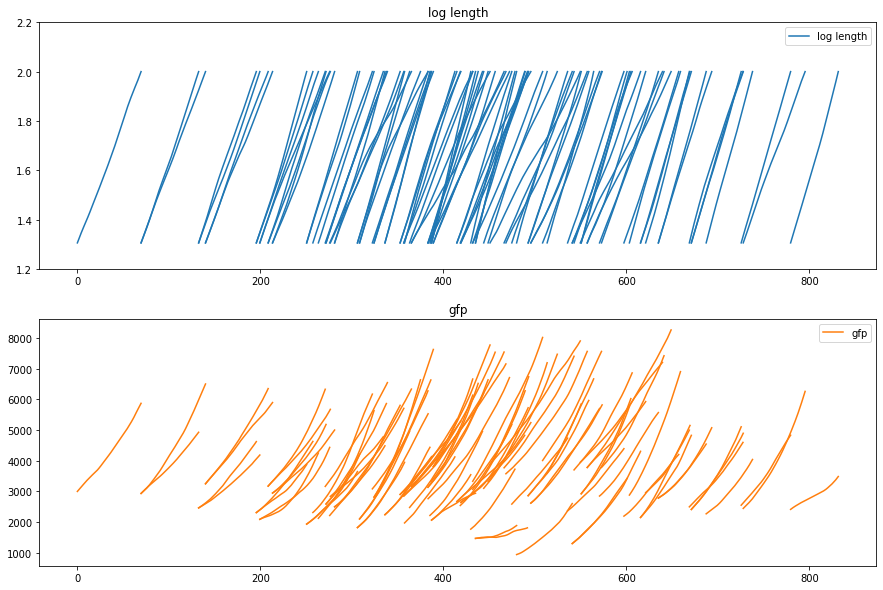

In [6]:
fig, axes = plt.subplots(2, figsize=(15,10))
ax = axes.ravel()

for j in range(len(cells_simulated[:100])):
    cell = copy.deepcopy(cells_simulated[j])
    cell.time = np.array(cell.time)

    ax[0].set_title("log length")
    ax[1].set_title("gfp")
    ax[0].set_ylim([1.2, 2.2])
    
    if len(cells_simulated) <20:
        ax[0].axvline(cell.time[-1], ls='--', color='tab:blue')
        ax[1].axvline(cell.time[-1], ls='--', color='tab:orange')

    if j ==0:
        ax[0].plot(cell.time, np.array(cell.log_length), label='log length', color='tab:blue')
        ax[1].plot(cell.time, np.array(cell.gfp), color='tab:orange', label='gfp')

    else:
        ax[0].plot(cell.time, np.array(cell.log_length), color='tab:blue')
        ax[1].plot(cell.time, np.array(cell.gfp), color='tab:orange')

for j in range(2):
    ax[j].legend()

In [7]:
from treelib import Node, Tree

tree = Tree()
for i in range(len(cells_simulated)):
    if cells_simulated[i].parent_id>=0:
        tree.create_node(cells_simulated[i].cell_id,  cells_simulated[i].cell_id, parent=cells_simulated[i].parent_id)
    else:
        tree.create_node(cells_simulated[i].cell_id,  cells_simulated[i].cell_id)
tree.show()

0
├── 1
│   ├── 7
│   │   ├── 13
│   │   │   └── 80
│   │   └── 14
│   │       └── 16
│   │           ├── 19
│   │           │   └── 108
│   │           └── 20
│   │               └── 148
│   │                   └── 155
│   │                       └── 176
│   └── 8
│       ├── 9
│       │   ├── 33
│       │   └── 34
│       └── 10
│           ├── 17
│           │   ├── 31
│           │   │   ├── 41
│           │   │   │   ├── 55
│           │   │   │   │   └── 64
│           │   │   │   │       ├── 69
│           │   │   │   │       │   └── 113
│           │   │   │   │       └── 70
│           │   │   │   └── 56
│           │   │   └── 42
│           │   │       └── 75
│           │   │           └── 144
│           │   │               └── 180
│           │   └── 32
│           │       ├── 81
│           │       └── 82
│           │           ├── 111
│           │           │   ├── 145
│           │           │   │   └── 161
│           │           │   └── 146
│           │           




## Cecking dt dependence 

No cells (dt=1.000): 4
No cells (dt=0.100): 3
No cells (dt=0.010): 3
No cells (dt=0.001): 4


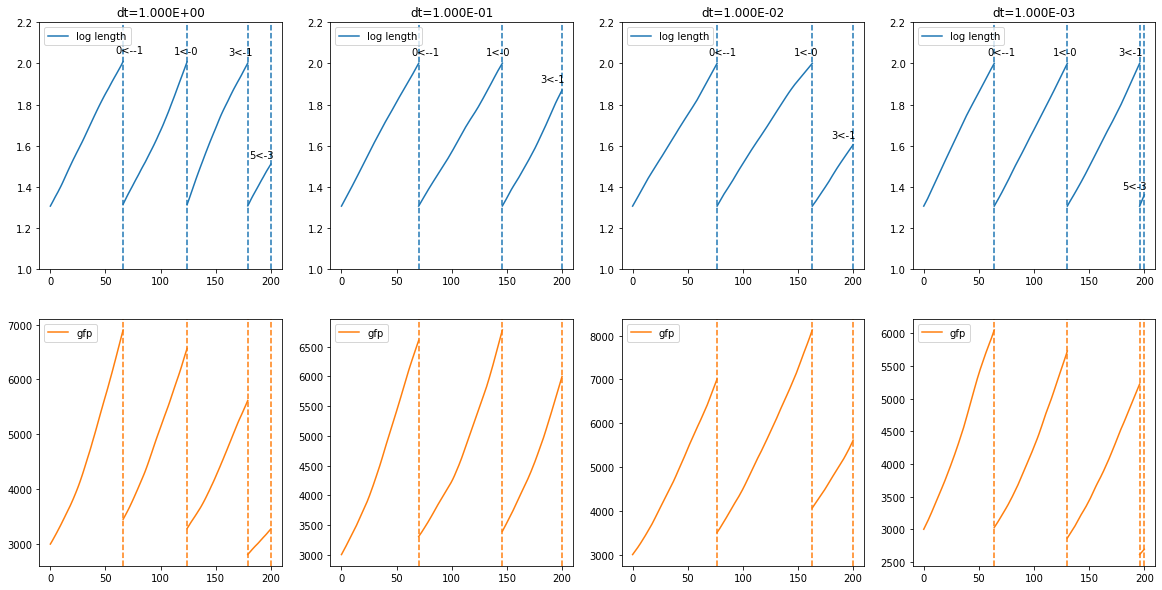

In [8]:
total_time = 200
dt_list = [1, 0.1, 0.01, 0.001]
fig, ax = plt.subplots(2,len(dt_list), figsize=(20,10))
for i, dt in enumerate(dt_list):
    no_cells = 0
    gfp0 = 3*mean_q/mean_lambda
    cell = Cell(division_log_length-np.log(2), gfp0, mean_lambda, mean_q)

    lambda_ou = full_ou_process(dt, mean_lambda, gamma_lambda, var_lambda, int(total_time/dt))
    q_ou = full_ou_process(dt, mean_q, gamma_q, var_q, int(total_time/dt))
    cell_list = []

    for t in range( int(total_time/dt) ):
        cell.time.append(cell.time[-1]+dt)

        q_ou = single_ou_step(dt, mean_q, gamma_q, var_q, cell.qt[-1]) 
        cell = gfp_production(cell, dt, q_ou, beta)

        lambda_ou = single_ou_step(dt, mean_lambda, gamma_lambda, var_lambda, cell.lambda_t[-1]) 
        cell = growth(cell, dt, lambda_ou)

        if cell.log_length[-1] > division_log_length:
            cell_list.append(cell) 
            cell1, cell2, no_cells = cell_divsion(cell, division_log_length, var_dx, var_dg, gfp0, mean_lambda, mean_q, no_cells)
            cell = cell1 # discard second daughter cell here
    cell_list.append(copy.deepcopy(cell))
    
    print("No cells (dt={:.3f}): {:d}".format(dt, len(cell_list)))

    for j in range(len(cell_list)):
        cell = cell_list[j]
        cell.time = np.array(cell.time)
        cell_list.append(copy.deepcopy(cell))

        ax[0,i].set_title("dt={:.3E}".format(dt))
        ax[0,i].text(cell.time[-1]*0.9, cell.log_length[-1]*1.02, '{:d}<-{:d}'.format(cell.cell_id, cell.parent_id))

        ax[0,i].set_ylim([1, 2.2])
        ax[0,i].axvline(cell.time[-1], ls='--', color='tab:blue')
        ax[1,i].axvline(cell.time[-1], ls='--', color='tab:orange')

        if j ==0:
            ax[0,i].plot(cell.time, np.array(cell.log_length), label='log length', color='tab:blue')
            ax[1,i].plot(cell.time, np.array(cell.gfp), color='tab:orange', label='gfp')
        else:
            ax[1,i].plot(cell.time, np.array(cell.gfp), color='tab:orange')
            ax[0,i].plot(cell.time, np.array(cell.log_length), color='tab:blue')

    for j in range(2):
        ax[j,i].legend()

plt.show()